In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pyproj import Transformer

## 데이터 불러오기

### 읍·면·동 행정 구역 별 2022-2024 산불 발생 확률 예측 데이터

In [2]:
emd_predict_df = pd.read_csv('../2022131621/data/Fire_Prob_EMD.csv')
emd_predict_df.head()

,Unnamed: 0,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,predicted
0,0,11110101,Cheongun-dong,청운동,17.456719
1,1,11110102,Singyo-dong,신교동,16.428787
2,2,11110103,Gungjeong-dong,궁정동,15.029155
3,3,11110109,Nusang-dong,누상동,22.567163
4,4,11110111,Ogin-dong,옥인동,26.730504


`Unnamed: 0` 컬럼 제거

In [3]:
emd_predict_df.drop(columns=['Unnamed: 0'], inplace=True)
emd_predict_df.head()

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,predicted
0,11110101,Cheongun-dong,청운동,17.456719
1,11110102,Singyo-dong,신교동,16.428787
2,11110103,Gungjeong-dong,궁정동,15.029155
3,11110109,Nusang-dong,누상동,22.567163
4,11110111,Ogin-dong,옥인동,26.730504


### 읍·면·동 행정 구역 경계 지도 데이터

In [4]:
emd_gdf = gpd.read_file("../data/emd_20230729/emd.shp", encoding='euc-kr')
emd_gdf.geometry = emd_gdf.geometry.set_crs('EPSG:5179')
emd_gdf.geometry = emd_gdf.geometry.to_crs('EPSG:4326')
emd_gdf.head()

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589..."
1,11110102,Singyo-dong,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((126.97400 37.58654, 126.97401 37.586..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582..."
4,11110105,Changseong-dong,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581..."


## 각 읍·면·동 경계 내 무작위 균등 좌표 추출

읍·면·동 별 산불 발생 확률을 기반으로 한 실제 산불 발생 사건을 모사하기 위해 각 행정 구역으로부터 무작위로 좌표를 추출한다.

**단위 면적 당** 좌표의 추출 개수는 발생 확률의 상수배이다. 따라서, 추출 개수는 **읍면동의 면적에 확률을 곱한 것**으로 한다.

In [5]:
# 각 읍·면·동 행정 구역 코드를 Key, 예측된 화재 발생 확률을 Value로 하는 딕셔너리 생성
prediction_by_emd = dict(zip(emd_predict_df['EMD_CD'].astype(int), emd_predict_df['predicted'] / 100.0))

# 각 읍·면·동 행정 구역별 화재 발생 확률 계산
prediction = emd_gdf['EMD_CD'].astype(int).map(prediction_by_emd)

# 결측치 처리
prediction.fillna(0, inplace=True)

In [6]:
# 각 읍·면·동 행정 구역 별 면적 계산: Cartesian 좌표계로 변환
emd_gdf_cartesian = emd_gdf.to_crs('EPSG:3857')
emd_area = emd_gdf_cartesian.geometry.area

# 예측된 화재 발생 확률을 면적으로 가중치 조정
prediction *= emd_area

In [7]:
TOTAL_SAMPLES = 10000 # 총 샘플링할 점의 수
sample_counts = (prediction / prediction.sum() * TOTAL_SAMPLES).round().astype(int)

sampled_points_cartesian = emd_gdf_cartesian.sample_points(sample_counts).explode()
sampled_points = sampled_points_cartesian.to_crs('EPSG:4326')

/opt/homebrew/lib/python3.11/site-packages/geopandas/tools/_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  return GeoSeries(candidates[:size]).unary_union
/opt/homebrew/lib/python3.11/site-packages/geopandas/tools/_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  return GeoSeries(candidates[:size]).unary_union
/opt/homebrew/lib/python3.11/site-packages/geopandas/tools/_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  return GeoSeries(candidates[:size]).unary_union
/opt/homebrew/lib/python3.11/site-packages/geopandas/tools/_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTIO

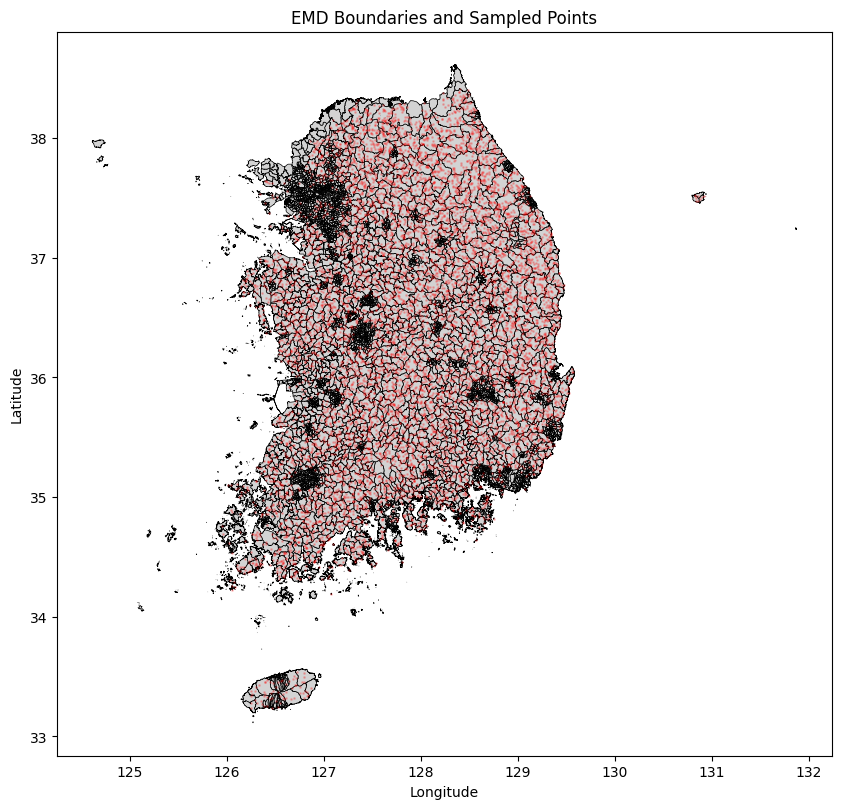

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

emd_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)

ax.scatter(sampled_points.values.x, sampled_points.values.y, s=1, color='red', alpha=0.2)
ax.set_title('EMD Boundaries and Sampled Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

울릉도 내 추출된 좌표는 제외한다 (K-means outlier).

In [9]:
except_ulleungdo = sampled_points[sampled_points.values.x < 130]
xx = except_ulleungdo.values.x
yy = except_ulleungdo.values.y

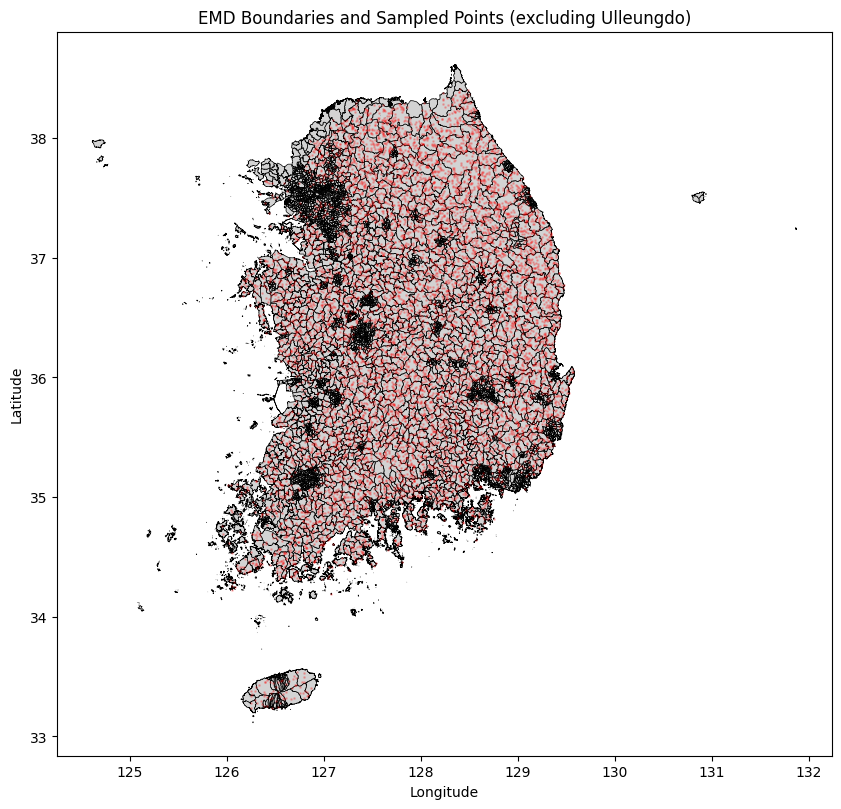

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
emd_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)
ax.scatter(xx, yy, s=1, color='red', alpha=0.2)
ax.set_title('EMD Boundaries and Sampled Points (excluding Ulleungdo)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

## K-means++ 기반 클러스터링

In [11]:
cluster_count = 17 # 총 소방항공대 수

kmeans_plus = KMeans(n_clusters=cluster_count, init='k-means++')

except_ulleungdo_cartesian = except_ulleungdo.to_crs('EPSG:3857')
xx_cartesian = except_ulleungdo_cartesian.values.x
yy_cartesian = except_ulleungdo_cartesian.values.y

clusters = kmeans_plus.fit(np.column_stack((xx_cartesian, yy_cartesian)))

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
# EPSG:3857 (Web Mercator) -> EPSG:4326 (WGS84)
transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
centers = np.array([transformer.transform(x, y) for x, y in kmeans_plus.cluster_centers_])
centers

array([[128.06573135,  35.80105236],
       [128.71363378,  37.40686167],
       [128.17278113,  36.70145761],
       [127.91611001,  37.3848109 ],
       [127.31816631,  34.92256875],
       [128.94286454,  36.215034  ],
       [126.73351595,  36.5370321 ],
       [127.24079438,  37.05836694],
       [128.98954358,  35.56968985],
       [127.52523105,  36.22459371],
       [129.05701029,  36.85029426],
       [126.60156948,  34.76223651],
       [128.28502511,  37.97009241],
       [126.54352254,  33.37611863],
       [128.12934887,  35.16639193],
       [127.38098317,  37.88905821],
       [127.12797345,  35.53694035]])

In [13]:
sorted_centers_by_y = centers[centers[:,1].argsort()[::-1]]
sorted_centers_by_y

array([[128.28502511,  37.97009241],
       [127.38098317,  37.88905821],
       [128.71363378,  37.40686167],
       [127.91611001,  37.3848109 ],
       [127.24079438,  37.05836694],
       [129.05701029,  36.85029426],
       [128.17278113,  36.70145761],
       [126.73351595,  36.5370321 ],
       [127.52523105,  36.22459371],
       [128.94286454,  36.215034  ],
       [128.06573135,  35.80105236],
       [128.98954358,  35.56968985],
       [127.12797345,  35.53694035],
       [128.12934887,  35.16639193],
       [127.31816631,  34.92256875],
       [126.60156948,  34.76223651],
       [126.54352254,  33.37611863]])

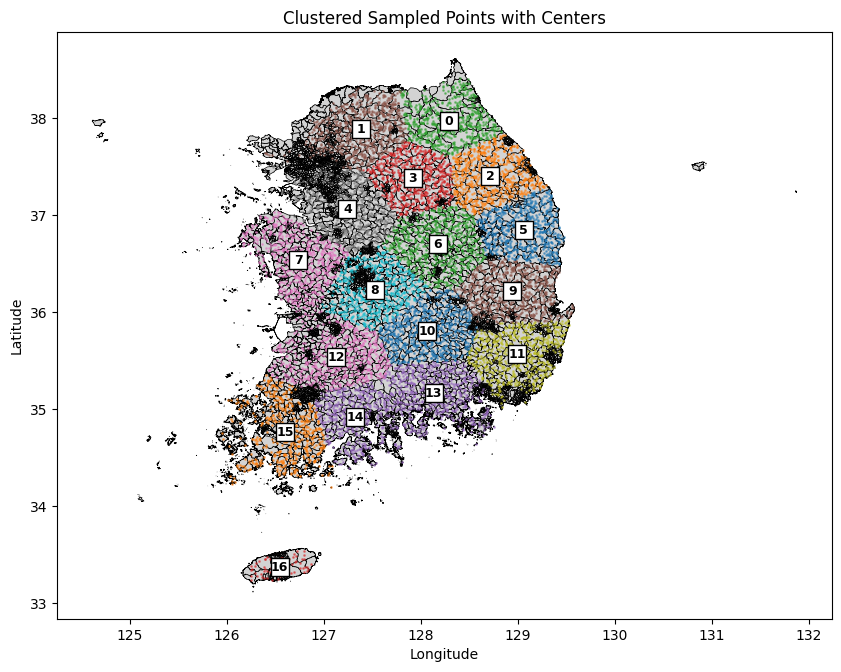

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

emd_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)

for i in range(cluster_count):
    cluster_xx = xx[clusters.labels_ == i]
    cluster_yy = yy[clusters.labels_ == i]
    ax.scatter(cluster_xx, cluster_yy, s=1, label=i, alpha=0.5)

plt.scatter(sorted_centers_by_y[:, 0], sorted_centers_by_y[:, 1], c='white', edgecolors='black', marker='s', s=150, label='Centers')
for i, (lon, lat) in enumerate(sorted_centers_by_y):
    plt.text(lon, lat, str(i), fontsize=9, color='black', ha='center', va='center', fontweight='bold')

ax.set_title('Clustered Sampled Points with Centers')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')
plt.show()

## 각 클러스터 중심(소방항공대)의 평균·최대 이동 거리 계산

In [15]:
for i in range(cluster_count):
    cluster_xx = xx[clusters.labels_ == i]
    cluster_yy = yy[clusters.labels_ == i]

    # 클러스터의 중심 좌표
    center = centers[i]
    
    # Haversine 거리 계산
    cluster_xx_rad = np.radians(cluster_xx)
    cluster_yy_rad = np.radians(cluster_yy)
    center_x_rad = np.radians(center[0])
    center_y_rad = np.radians(center[1])
    distances = np.arccos(np.sin(cluster_yy_rad) * np.sin(center_y_rad) +
                          np.cos(cluster_yy_rad) * np.cos(center_y_rad) *
                          np.cos(cluster_xx_rad - center_x_rad)) * 6371  # 지구 반지름 (km)

    # 평균 거리와 최대 거리 계산
    avg_distance = np.mean(distances)
    max_distance = np.max(distances)

    print(f"Cluster {i}: 평균 거리 = {avg_distance:.4f} km, 최대 거리 = {max_distance:.4f} km")

Cluster 0: 평균 거리 = 28.4315 km, 최대 거리 = 51.6010 km
Cluster 1: 평균 거리 = 27.3275 km, 최대 거리 = 52.3896 km
Cluster 2: 평균 거리 = 29.6084 km, 최대 거리 = 52.2340 km
Cluster 3: 평균 거리 = 26.5237 km, 최대 거리 = 46.5118 km
Cluster 4: 평균 거리 = 27.6637 km, 최대 거리 = 68.0743 km
Cluster 5: 평균 거리 = 29.1476 km, 최대 거리 = 59.8259 km
Cluster 6: 평균 거리 = 31.4677 km, 최대 거리 = 61.3480 km
Cluster 7: 평균 거리 = 31.3408 km, 최대 거리 = 95.3173 km
Cluster 8: 평균 거리 = 29.1567 km, 최대 거리 = 62.2602 km
Cluster 9: 평균 거리 = 28.6946 km, 최대 거리 = 51.8496 km
Cluster 10: 평균 거리 = 27.1258 km, 최대 거리 = 51.0669 km
Cluster 11: 평균 거리 = 34.0899 km, 최대 거리 = 77.7967 km
Cluster 12: 평균 거리 = 27.6219 km, 최대 거리 = 55.9555 km
Cluster 13: 평균 거리 = 17.1473 km, 최대 거리 = 31.3626 km
Cluster 14: 평균 거리 = 30.3915 km, 최대 거리 = 71.0728 km
Cluster 15: 평균 거리 = 29.3325 km, 최대 거리 = 90.9151 km
Cluster 16: 평균 거리 = 31.7393 km, 최대 거리 = 64.3452 km
